In [ ]:
#Performing stance detection (Opinion mining) for tweets based on misinformation targets using the BERT model

In [7]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from google.colab import drive
import logging
import nltk
import re
import pickle
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import trange

!pip install pytorch_transformers 
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.autograd import Variable
from pytorch_transformers import BertConfig, BertTokenizer, BertModel, AdamW
from sklearn.metrics import f1_score, confusion_matrix

     |████████████████████████████████| 176 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 131 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 1.7 MB/s eta 0:00:01     |████████▉                       | 2.2 MB 2.2 MB/s eta 0:00:03
     |████████████████████████████████| 79 kB 2.3 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


ModuleNotFoundError: No module named 'pytorch_transformers'

In [5]:
drive.mount('/content/drive')

NameError: name 'drive' is not defined

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harithav/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/harithav/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [9]:
# Word lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(' ')]
    text = [lemmatizer.lemmatize(token, 'v') for token in text]
    text = [word for word in text if word not in stop_words]
    text = ' '.join(text)
    text = text.lstrip().rstrip()
    text = re.sub(' +', ' ', text)
    return text

In [ ]:
logging.getLogger('pytorch_transformers').setLevel(logging.CRITICAL)

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("DEVICE FOUND: %s" % DEVICE)

DEVICE FOUND: cuda


In [ ]:
SEED = 123
torch.manual_seed(seed=SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# Initialize Hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 64

PRETRAINED_MODEL_NAME = 'bert-base-cased'
NUM_PRETRAINED_BERT_LAYERS = 1
MAX_TOKENIZATION_LENGTH = 512
NUM_CLASSES = 4 # agree, disagree, no_stance, not_relevant
TOP_DOWN = True
NUM_RECURRENT_LAYERS = 1
HIDDEN_SIZE = 256
REINITIALIZE_POOLER_PARAMETERS = True
USE_BIDIRECTIONAL = True
DROPOUT_RATE = 0.6
AGGREGATE_ON_CLS_TOKEN = True
CONCATENATE_HIDDEN_STATES = True

APPLY_CLEANING = True
TRUNCATION_METHOD = 'head-only'
NUM_WORKERS = 0

BERT_LEARNING_RATE = 1e-5
CUSTOM_LEARNING_RATE = 1e-4
BETAS = (0.9, 0.999)
BERT_WEIGHT_DECAY = 0.01
EPS = 1e-8

### Finetuned Bert Model

In [ ]:
targets = ["RNA alters a person's DNA when taking the COVID-19 vaccine.",
            "The COVID-19 vaccine causes infertility or miscarriages in women.",
            "Natural COVID-19 immunity is better than immunity derived from a COVID-19 vaccine.",
            "The COVID-19 vaccine causes Bell's palsy.",
            "The COVID-19 vaccine contains tissue from aborted fetuses.",
            "The COVID-19 vaccine was developed to control the general population either through microchip tracking or nanotransducers in our brains.",
            "More people will die as a result of a negative side effect to the COVID-19 vaccine than would actually die from the coronavirus.",
            "There are severe side effects of the coronavirus vaccines, worse than having the virus."]
target_idx = [1,2,3,4,7,8,9,10]

In [ ]:
class FineTunedBert(nn.Module):
    def __init__(self, pretrained_model_name, num_pretrained_bert_layers, max_tokenization_length, vocab_file = '',
                 num_classes=1, top_down=True, num_recurrent_layers=1, use_bidirectional=False,
                 hidden_size=128, reinitialize_pooler_parameters=False, dropout_rate=0.10,
                 aggregate_on_cls_token=True, concatenate_hidden_states=False, use_gpu=False):
        super(FineTunedBert, self).__init__()
        self.num_recurrent_layers = num_recurrent_layers
        self.use_bidirectional = use_bidirectional
        self.hidden_size = hidden_size
        self.aggregate_on_cls_token = aggregate_on_cls_token
        self.concatenate_hidden_states = concatenate_hidden_states
        self.use_gpu = use_gpu

        # Tokenizer
        self.tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)
        self.tokenizer.max_len = max_tokenization_length
        self.tokenizer.vocab_file = vocab_file

        # Obtain global BERT config
        self.config = BertConfig.from_pretrained(pretrained_model_name)
        # Extract all parameters (weights and bias matrices) for the 12 layers
        all_states_dict = BertModel.from_pretrained(pretrained_model_name,
                                                    config=self.config).state_dict()

        # Obtain customized BERT config
        self.config.max_position_embeddings = max_tokenization_length
        self.config.num_hidden_layers = num_pretrained_bert_layers
        self.config.output_hidden_states = True
        self.config.output_attentions = True

        # Obtain pretrained BERT model & all its learnable parameters
        self.bert = BertModel.from_pretrained(pretrained_model_name,
                                              config=self.config)
        current_states_dict = self.bert.state_dict()

        if top_down:
            for param in current_states_dict.keys():
                if 'pooler' not in param or not reinitialize_pooler_parameters:
                    current_states_dict[param] = all_states_dict[param]
                else:
                    if 'weight' in param:
                        current_states_dict[param] = torch.ones(self.config.hidden_size,
                                                                self.config.hidden_size)
                    elif 'bias' in param:
                        current_states_dict[param] = torch.zeros(self.config.hidden_size)

        else:
            align = 5 + ((12 - num_pretrained_bert_layers) * 16)
            for index, param in enumerate(current_states_dict.keys()):
                # There are 5 initial (shared) parameters from embeddings in each BERT model
                if index < 5 and 'embeddings' in param:
                    current_states_dict[param] = all_states_dict[param]
                # There are 16 parameters for each of the K pretrained BERT layers (16 x K params)
                elif index >= 5 and 'pooler' not in param:
                    current_states_dict[param] = list(all_states_dict.values())[align:][index-5]
                # There are 2 parameters for the pooling layer at the end in each BERT model
                else:
                    if not reinitialize_pooler_parameters:
                        current_states_dict[param] = all_states_dict[param]
                    else:
                        if 'weight' in param:
                            current_states_dict[param] = torch.ones(self.config.hidden_size,
                                                                    self.config.hidden_size)
                        elif 'bias' in param:
                            current_states_dict[param] = torch.zeros(self.config.hidden_size)

        del all_states_dict
        self.bert.load_state_dict(current_states_dict)

        logging.info('Loaded %d learnable parameters from pretrained BERT model with %d layer(s)' %
                     (len(list(self.bert.parameters())), num_pretrained_bert_layers))

        # Number of input hidden dimensions from the final BERT layer, as input to other layers
        input_hidden_dimension = None
        if concatenate_hidden_states:
            input_hidden_dimension = (num_pretrained_bert_layers + 1) * self.config.hidden_size
        else:
            input_hidden_dimension = self.config.hidden_size

        self.flatten_sequence_length = lambda t: t.view(-1,
                                                        self.config.max_position_embeddings *
                                                        input_hidden_dimension)

        self.dropout = nn.Dropout(p=dropout_rate)
        if self.num_recurrent_layers > 0:
            self.lstm = nn.LSTM(input_size=input_hidden_dimension,
                                hidden_size=hidden_size,
                                num_layers=num_recurrent_layers,
                                bidirectional=use_bidirectional,
                                batch_first=True)
            self.clf = nn.Linear(in_features=hidden_size*2 if use_bidirectional else hidden_size,
                                 out_features=num_classes)
        else:
            if aggregate_on_cls_token:
                self.clf = nn.Linear(in_features=input_hidden_dimension,
                                     out_features=num_classes)
            else:
                self.clf = nn.Linear(in_features=max_tokenization_length * input_hidden_dimension,
                                     out_features=num_classes)

    def get_tokenizer(self):
        """Function to easily access the BERT tokenizer"""
        return self.tokenizer

    def get_bert_attention(self, raw_sentence, header, device):
        """Function for getting the multi-head self-attention output from pretrained BERT"""
        x = tokenize_and_encode(text=raw_sentence,                             
                                header=header,
                                tokenizer=self.get_tokenizer(),
                                max_tokenization_length=self.config.max_position_embeddings,
                                truncation_method='head-only')
        x = torch.tensor(data=x, device=device)
        x = x.unsqueeze(dim=1).view(1, -1)                                     

        token_type_ids, attention_mask = get_features(input_ids=x,
                                                      tokenizer=self.get_tokenizer(),
                                                      device=device)
        bert_outputs = self.bert(input_ids=x,                                  
                                 token_type_ids=token_type_ids,
                                 attention_mask=attention_mask,
                                 position_ids=None,
                                 head_mask=None)
        attention_outputs = bert_outputs[3]                                    
        return attention_outputs

    def predict(self, text, header_id):
        header = targets[target_idx.index(header_id)]
        stance_input_ids = tokenize_and_encode(text, 
                                               self.get_tokenizer(), 
                                               header, 
                                               apply_cleaning=APPLY_CLEANING,
                                               max_tokenization_length=MAX_TOKENIZATION_LENGTH,
                                               truncation_method=TRUNCATION_METHOD)
        stance_input_ids = torch.from_numpy(np.array(stance_input_ids).reshape(1, -1)).long().to(DEVICE)
        stance_token_id, stance_attention_mask = get_features(stance_input_ids,
                                                              tokenizer=self.get_tokenizer(),
                                                              device=DEVICE)
        return self.forward(input_ids=stance_input_ids,
                            token_type_ids=stance_token_id,
                            attention_mask=stance_attention_mask)
  
    def forward(self, input_ids, token_type_ids=None, attention_mask=None,     
                position_ids=None, head_mask=None):
        """Function implementing a forward pass of the model"""
        bert_outputs = self.bert(input_ids=input_ids,
                                 token_type_ids=token_type_ids,
                                 attention_mask=attention_mask,
                                 position_ids=position_ids,
                                 head_mask=head_mask)
        sequence_output = bert_outputs[0]                                      
        pooled_output = bert_outputs[1]                                        
        hidden_outputs = bert_outputs[2]                                       
        attention_outputs = bert_outputs[3]                                    

        if self.concatenate_hidden_states:
            sequence_output = torch.cat(hidden_outputs, dim=-1)               

        if self.num_recurrent_layers > 0:
            if self.use_gpu:
                h0 = Variable(torch.zeros(self.num_recurrent_layers * 2        
                                          if self.use_bidirectional else self.num_recurrent_layers,
                                          input_ids.shape[0],
                                          self.hidden_size)).cuda()
                c0 = Variable(torch.zeros(self.num_recurrent_layers * 2        
                                          if self.use_bidirectional else self.num_recurrent_layers,
                                          input_ids.shape[0],
                                          self.hidden_size)).cuda()
            else:
                h0 = Variable(torch.zeros(self.num_recurrent_layers * 2        
                                          if self.use_bidirectional else self.num_recurrent_layers,
                                          input_ids.shape[0],
                                          self.hidden_size))
                c0 = Variable(torch.zeros(self.num_recurrent_layers * 2        
                                          if self.use_bidirectional else self.num_recurrent_layers,
                                          input_ids.shape[0],
                                          self.hidden_size))

            lstm_output = self.lstm(sequence_output, (h0, c0))                 )
            sequence_output, _ = lstm_output

            last_timesteps = []
            for i in range(len(attention_mask)):
                last_timesteps.append(
                    attention_mask[i].tolist().index(0)
                    if 0 in attention_mask[i].tolist() else self.tokenizer.max_len - 1
                )

            if self.use_gpu:
                last_timesteps = torch.tensor(data=last_timesteps).cuda()      
            else:
                last_timesteps = torch.tensor(data=last_timesteps)             
            relative_hidden_size = self.hidden_size*2 if self.use_bidirectional else self.hidden_size
            last_timesteps = last_timesteps.repeat(1, relative_hidden_size)    
            last_timesteps = last_timesteps.view(-1, 1, relative_hidden_size)  
            pooled_sequence_output = sequence_output.gather(                   
                dim=1,
                index=last_timesteps
            ).squeeze()

            pooled_sequence_output = self.dropout(pooled_sequence_output)      
            logits = self.clf(pooled_sequence_output)                          
        else:
            if not self.aggregate_on_cls_token:
                pooled_output = self.flatten_sequence_length(sequence_output)  

            pooled_output = self.dropout(pooled_output)                        
            logits = self.clf(pooled_output)                                  

        return logits                                                          

In [ ]:
model = FineTunedBert(pretrained_model_name=PRETRAINED_MODEL_NAME,
                      vocab_file="drive/MyDrive/TwitterProject/data/vocabulary.txt",
                      num_pretrained_bert_layers=NUM_PRETRAINED_BERT_LAYERS,
                      max_tokenization_length=MAX_TOKENIZATION_LENGTH,
                      num_classes=NUM_CLASSES,
                      top_down=TOP_DOWN,
                      num_recurrent_layers=NUM_RECURRENT_LAYERS,
                      use_bidirectional=USE_BIDIRECTIONAL,
                      hidden_size=HIDDEN_SIZE,
                      reinitialize_pooler_parameters=REINITIALIZE_POOLER_PARAMETERS,
                      dropout_rate=DROPOUT_RATE,
                      aggregate_on_cls_token=AGGREGATE_ON_CLS_TOKEN,
                      concatenate_hidden_states=CONCATENATE_HIDDEN_STATES,
                      use_gpu=True if torch.cuda.is_available() else False)

In [ ]:
def tokenize_and_encode(text, tokenizer, header='', apply_cleaning=False, max_tokenization_length=512,
                        truncation_method='head-only', split_head_density=0.5):
    """
    Function to tokenize & encode a given text.
    @param (str) text: a sequence of words to be tokenized in raw string format
    @param (pytorch_transformers.BertTokenizer) tokenizer: tokenizer with pre-figured mappings
    @param (bool) apply_cleaning: whether or not to perform common cleaning operations on texts;
           note that enabling only makes sense if language of the task is English (default: False)
    @param (int) max_tokenization_length: maximum number of positional embeddings, or the sequence
           length of an example that will be fed to BERT model (default: 512)
    @param (str) truncation_method: method that will be applied in case the text exceeds
           @max_tokenization_length; currently implemented methods include 'head-only', 'tail-only',
           and 'head+tail' (default: 'head-only')
    @param (float) split_head_density: weight on head when splitting between head and tail, only
           applicable if @truncation_method='head+tail' (default: 0.5)
    @return (list) input_ids: the encoded integer indexes of the given text; note that
            get_data_iterators() function converts this to a Tensor under the hood
    """
    if apply_cleaning:
        text = clean_text(text=text)

    # Tokenize and encode
    tokenized_text = tokenizer.tokenize(text)
    input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokenized_header = tokenizer.tokenize(header)
    header_ids = tokenizer.convert_tokens_to_ids(tokenized_header)

    text_tokenization_length = max_tokenization_length - 3 - len(header_ids)
    if len(input_ids) > text_tokenization_length:
        if truncation_method == 'head-only':
            input_ids = input_ids[:text_tokenization_length]
        elif truncation_method == 'tail-only':
            input_ids = input_ids[-text_tokenization_length:]
        elif truncation_method == 'head+tail':
            head_tokenization_length = int(text_tokenization_length * split_head_density)
            tail_tokenization_length = text_tokenization_length - head_tokenization_length
            input_head_ids = input_ids[:head_tokenization_length]
            input_tail_ids = input_ids[-tail_tokenization_length:]
            input_ids = input_head_ids + input_tail_ids  

    cls_id = tokenizer.convert_tokens_to_ids('[CLS]')
    sep_id = tokenizer.convert_tokens_to_ids('[SEP]')
    input_ids = [cls_id] + header_ids + [sep_id] + input_ids + [sep_id]


    pad_id = tokenizer.convert_tokens_to_ids('[PAD]')
    if len(input_ids) < max_tokenization_length:
        padding_length = max_tokenization_length - len(input_ids)
        input_ids = input_ids + ([pad_id] * padding_length)

    return input_ids


def get_features(input_ids, tokenizer, device):
    token_type_ids, attention_mask = [], []

    for input_ids_example in input_ids:
        input_ids_example = input_ids_example.squeeze().tolist()
        if input_ids.shape[0] == 1:
            input_ids_example = input_ids.squeeze().tolist()
        padding_token_id = tokenizer.convert_tokens_to_ids('[PAD]')
        padding_length = input_ids_example.count(padding_token_id)
        text_length = len(input_ids_example) - padding_length

        token_type_ids_example = [0] * len(input_ids_example)
        attention_mask_example = ([1] * text_length) + ([0] * padding_length)

        assert len(token_type_ids_example) == len(input_ids_example)
        assert len(attention_mask_example) == len(input_ids_example)
        token_type_ids.append(token_type_ids_example)
        attention_mask.append(attention_mask_example)

    token_type_ids = torch.tensor(data=token_type_ids, device=device)
    attention_mask = torch.tensor(data=attention_mask, device=device)
    return token_type_ids, attention_mask

In [ ]:
#Dataset
class TweetDataset(Dataset):
    def __init__(self, input_directory, tokenizer, apply_cleaning, max_tokenization_length,
                 truncation_method='head-only', split_head_density=0.5, device='cpu'):
        super(TweetDataset).__init__()
        # agree folder
        self.agree_path = os.path.join(input_directory, 'agree')
        self.agree_files = [f for f in os.listdir(self.agree_path)
                               if os.path.isfile(os.path.join(self.agree_path, f))]
        self.num_agree_examples = len(self.agree_files)
        self.agree_label = 0
        
        self.disagree_path = os.path.join(input_directory, 'disagree')
        self.disagree_files = [f for f in os.listdir(self.disagree_path)
                               if os.path.isfile(os.path.join(self.disagree_path, f))]
        self.num_disagree_examples = len(self.disagree_files)
        self.disagree_label = 1

        self.nostance_path = os.path.join(input_directory, 'no_stance')
        self.nostance_files = [f for f in os.listdir(self.nostance_path)
                               if os.path.isfile(os.path.join(self.nostance_path, f))]
        self.num_nostance_examples = len(self.nostance_files)
        self.nostance_label = 2

        self.notrelevant_path = os.path.join(input_directory, 'not_relevant')
        self.notrelevant_files = [f for f in os.listdir(self.notrelevant_path)
                               if os.path.isfile(os.path.join(self.notrelevant_path, f))]
        self.num_notrelevant_examples = len(self.notrelevant_files)
        self.notrelevant_label = 3

        self.tokenizer = tokenizer
        self.apply_cleaning = apply_cleaning
        self.max_tokenization_length = max_tokenization_length
        self.truncation_method = truncation_method
        self.split_head_density = split_head_density
        self.device = device

        self.pre_tokenize_and_encode_examples()

    def pre_tokenize_and_encode_examples(self):
        self.__pre_tokenize_and_encode_examples__(self.agree_path, self.agree_files)
        self.__pre_tokenize_and_encode_examples__(self.disagree_path, self.disagree_files)
        self.__pre_tokenize_and_encode_examples__(self.nostance_path, self.nostance_files)
        self.__pre_tokenize_and_encode_examples__(self.notrelevant_path, self.notrelevant_files)

    def __pre_tokenize_and_encode_examples__(self, path, files):
        if not os.path.exists(os.path.join(path, 'tokenized_and_encoded')):
            os.mkdir(os.path.join(path, 'tokenized_and_encoded'))

            for i in trange(len(files), desc='Tokenizing & Encoding {} Tweets'.format(path),
                            leave=True):
                file = files[i]
                m_id = int(file.split('_')[0])
                idx = target_idx.index(m_id)
                target = targets[idx]
                with open(os.path.join(path, file), mode='r', encoding='utf8') as f:
                    example = f.read()
                example = re.sub(r'<br />', '', example)
                example = example.lstrip().rstrip()
                example = re.sub(' +', ' ', example)
                example = tokenize_and_encode(text=example,
                                              header=target,
                                              tokenizer=self.tokenizer,
                                              apply_cleaning=self.apply_cleaning,
                                              max_tokenization_length=self.max_tokenization_length,
                                              truncation_method=self.truncation_method,
                                              split_head_density=self.split_head_density)

                with open(os.path.join(path, 'tokenized_and_encoded', file), mode='wb') as f:
                    pickle.dump(obj=example, file=f)
        else:
            logging.warning('Tokenized {} directory already exists!'.format(path))

    def __len__(self):
        return len(self.agree_files) + len(self.disagree_files) + len(self.nostance_files) + len(self.notrelevant_files)

    def __getitem__(self, index):
        # agree
        if index < self.num_agree_examples:
            file = self.agree_files[index]
            label = torch.tensor(data=self.agree_label, dtype=torch.long).to(self.device)
            with open(os.path.join(self.agree_path, 'tokenized_and_encoded', file), mode='rb') as f:
                example = pickle.load(file=f)
        elif index < self.num_agree_examples + self.num_disagree_examples:
            file = self.disagree_files[index - self.num_agree_examples]
            label = torch.tensor(data=self.disagree_label, dtype=torch.long).to(self.device)
            with open(os.path.join(self.disagree_path, 'tokenized_and_encoded', file), mode='rb') as f:
                example = pickle.load(file=f)
        elif index < self.num_agree_examples + self.num_disagree_examples + self.num_nostance_examples:
            file = self.nostance_files[index - self.num_agree_examples - self.num_disagree_examples]
            label = torch.tensor(data=self.nostance_label, dtype=torch.long).to(self.device)
            with open(os.path.join(self.nostance_path, 'tokenized_and_encoded', file), mode='rb') as f:
                example = pickle.load(file=f)
        elif index < self.num_agree_examples + self.num_disagree_examples + self.num_nostance_examples + self.num_notrelevant_examples:
            file = self.notrelevant_files[index - self.num_agree_examples - self.num_disagree_examples - self.num_nostance_examples]
            label = torch.tensor(data=self.notrelevant_label, dtype=torch.long).to(self.device)
            with open(os.path.join(self.notrelevant_path, 'tokenized_and_encoded', file), mode='rb') as f:
                example = pickle.load(file=f)
        else:
            raise ValueError('Out of range index while accessing dataset')

        return torch.from_numpy(np.array(example)).long().to(self.device), label

In [ ]:
train_dataset = TweetDataset(input_directory="drive/MyDrive/TwitterProject/data/train",
                            tokenizer=model.get_tokenizer(),
                            apply_cleaning=True,
                            max_tokenization_length=MAX_TOKENIZATION_LENGTH,
                            truncation_method='head-only',
                            device=DEVICE)

test_dataset = TweetDataset(input_directory="drive/MyDrive/CS 6320 Project/data/test",
                           tokenizer=model.get_tokenizer(),
                           apply_cleaning=True,
                           max_tokenization_length=MAX_TOKENIZATION_LENGTH,
                           truncation_method='head-only',
                           device=DEVICE)

print(train_dataset)

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

criterion = nn.CrossEntropyLoss()

bert_learning_rate = BERT_LEARNING_RATE
custom_learning_rate = CUSTOM_LEARNING_RATE
bert_identifiers = ['embeddings']
no_weight_decay_identifiers = ['bias', 'LayerNorm.weight']
grouped_model_parameters = [
        {'params': [param for name, param in model.named_parameters()
                    if any(identifier in name for identifier in bert_identifiers) and
                    not any(identifier_ in name for identifier_ in no_weight_decay_identifiers)],
          'lr': bert_learning_rate,
          'betas': (0.9, 0.999),
          'weight_decay': 0.01,
          'eps': 1e-8},
        {'params': [param for name, param in model.named_parameters()
                    if any(identifier in name for identifier in bert_identifiers) and
                    any(identifier_ in name for identifier_ in no_weight_decay_identifiers)],
          'lr': bert_learning_rate,
          'betas': (0.9, 0.999),
          'weight_decay': 0.0,
          'eps': 1e-8},
        {'params': [param for name, param in model.named_parameters()
                    if not any(identifier in name for identifier in bert_identifiers)],
          'lr': custom_learning_rate,
          'betas': (0.9, 0.999),
          'weight_decay': 0.0,
          'eps': 1e-8}
]

optimizer = AdamW(grouped_model_parameters)


In [ ]:
model, criterion = model.to(DEVICE), criterion.to(DEVICE)

In [ ]:
def binary_accuracy(y_pred, y_true):
    y_pred_max = torch.argmax(y_pred, dim=-1)
    correct_pred = (y_pred_max == y_true).float()
    acc = correct_pred.sum() / len(correct_pred)
    return acc


def train(model, iterator, criterion, optimizer, device, include_bert_masks=True):
    epoch_loss, epoch_acc = 0.0, 0.0

    for batch in iterator:
        input_ids, labels = batch
        token_type_ids, attention_mask = get_features(input_ids=input_ids,
                                                      tokenizer=model.get_tokenizer(),
                                                      device=device)
        optimizer.zero_grad()
        if include_bert_masks:
            predictions = model(input_ids=input_ids,
                                token_type_ids=token_type_ids,
                                attention_mask=attention_mask)
        else:
            predictions = model(input_ids=input_ids,header_ids=header_ids)

        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def test(model, iterator, criterion, device, include_bert_masks=True):
    epoch_loss, epoch_acc = 0.0, 0.0
    confusion = [[0 for _ in range(0, 4)] for _ in range(0, 4)]

    with torch.no_grad():
        for batch in iterator:
            input_ids, labels = batch
            token_type_ids, attention_mask = get_features(input_ids=input_ids,
                                                          tokenizer=model.get_tokenizer(),
                                                          device=device)
            if include_bert_masks:
                predictions = model(input_ids=input_ids,
                                    token_type_ids=token_type_ids,
                                    attention_mask=attention_mask)
            else:
                predictions = model(input_ids=input_ids)

            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            y_pred_max = torch.argmax(predictions, dim=-1)
            confusion += confusion_matrix(labels.cpu().detach().numpy(),y_pred_max.cpu().detach().numpy(),labels=[0,1,2,3])
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    
    return epoch_loss / len(iterator), epoch_acc / len(iterator), confusion


def get_attention_nth_layer_mth_head_kth_token(attention_outputs, n, m, k, average_heads=False):
    if average_heads is True and m is not None:
        logging.warning("Argument passed for param @m will be ignored because of head averaging.")

    attention_outputs_concatenated = torch.cat(attention_outputs, dim=0)       
    attention_outputs = attention_outputs_concatenated.data[n, :, :, :]        

    attention_outputs = attention_outputs[:, k, :]                             

    if average_heads:
        attention_outputs = torch.sum(attention_outputs, dim=0)               
        num_attention_heads = attention_outputs_concatenated.shape[1]
        attention_outputs /= num_attention_heads
    else:
        attention_outputs = attention_outputs[m, :]                           

    return attention_outputs


def get_attention_average_first_layer(attention_outputs):
    return get_attention_nth_layer_mth_head_kth_token(attention_outputs=attention_outputs,
                                                      n=0, m=None, k=0,
                                                      average_heads=True)


def get_attention_average_last_layer(attention_outputs):
    return get_attention_nth_layer_mth_head_kth_token(attention_outputs=attention_outputs,
                                                      n=-1, m=None, k=0,
                                                      average_heads=True)


def get_normalized_attention(model, raw_sentence, method='last_layer_heads_average',
                             n=None, m=None, k=None, exclude_special_tokens=True,
                             normalization_method='normal', device='cpu'):
    if None in [n, m, k] and method == 'custom':
        raise ValueError("Must pass integer argument for params @n, @m, and @k " +
                         "if method is 'nth_layer_mth_head_kth_token'")
    elif None not in [n, m, k] and method != 'custom':
        logging.warning("Arguments passed for params @n, @m, or @k will be ignored. " +
                        "Specify @method as 'nth_layer_mth_head_kth_token' to make them effective.")

    if '[CLS]' not in raw_sentence and '[SEP]' not in raw_sentence:
        tokenized_text = ['[CLS]'] + model.get_tokenizer().tokenize(raw_sentence) + ['[SEP]']
    else:
        tokenized_text = model.get_tokenizer().tokenize(raw_sentence)
    model.eval()
    with torch.no_grad():
        attention_outputs = model.get_bert_attention(raw_sentence=raw_sentence, device=device)

    attention_weights = None
    if method == 'first_layer_heads_average':
        attention_weights = get_attention_nth_layer_mth_head_kth_token(
            attention_outputs=attention_outputs,
            n=0, m=None, k=0,
            average_heads=True
        )
    elif method == 'last_layer_heads_average':
        attention_weights = get_attention_nth_layer_mth_head_kth_token(
            attention_outputs=attention_outputs,
            n=-1, m=None, k=0,
            average_heads=True
        )
    elif method == 'nth_layer_heads_average':
        attention_weights = get_attention_nth_layer_mth_head_kth_token(
            attention_outputs=attention_outputs,
            n=n, m=None, k=0,
            average_heads=True
        )
    elif method == 'nth_layer_mth_head':
        attention_weights = get_attention_nth_layer_mth_head_kth_token( 
            attention_outputs=attention_outputs,
            n=n, m=m, k=0,
            average_heads=False
        )
    elif method == 'custom':
        attention_weights = get_attention_nth_layer_mth_head_kth_token(
            attention_outputs=attention_outputs,
            n=n, m=m, k=k,
            average_heads=False
        )

    if exclude_special_tokens:
        tokenized_text, attention_weights = tokenized_text[1:-1], attention_weights[1:-1]

    if normalization_method == 'min-max':
        max_weight, min_weight = attention_weights.max(), attention_weights.min()
        attention_weights = (attention_weights - min_weight) / (max_weight - min_weight)

    elif normalization_method == 'normal':
        mu, std = attention_weights.mean(), attention_weights.std()
        attention_weights = (attention_weights - mu) / std

    attention_weights = attention_weights.data

    tokens_and_weights = []
    for index, token in enumerate(tokenized_text):
        tokens_and_weights.append((token, attention_weights[index].item()))

    return tokens_and_weights


def get_delta_attention(tokens_and_weights_pre, tokens_and_weights_post):
    tokens_and_weights_delta = []
    for i, token_and_weight in enumerate(tokens_and_weights_pre):
        token,  = token_and_weight[0],
        assert token == tokens_and_weights_post[i][0]

        pre_weight = token_and_weight[1]
        post_weight = tokens_and_weights_post[i][1]

        tokens_and_weights_delta.append((token, post_weight - pre_weight))

    return tokens_and_weights_delta

In [ ]:
#Training

best_test_loss = float('inf')
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
worst_test_count = 0
prev_test_loss = 0
epoch_count = 0

for epoch in range(NUM_EPOCHS):
    epoch_count += 1
    print("EPOCH NO: %d" % (epoch + 1))
    train_loss, train_acc = train(model=model,
                                  iterator=train_loader,
                                  criterion=criterion,
                                  optimizer=optimizer,
                                  device=DEVICE,
                                  include_bert_masks=True)
    
    test_loss, test_acc, confusion = test(model=model,
                              iterator=test_loader,
                              criterion=criterion,
                              device=DEVICE,
                              include_bert_masks=True)
    
    if test_loss > prev_test_loss:
        worst_test_count += 1
    if worst_test_count == 4:
        break
    prev_test_loss = test_loss

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'drive/MyDrive/TwitterProject/saved_models/BERT-stance-detection-drop-0.4.pt')

    print(f'\tTrain Loss: {train_loss:.3f} | Train Accuracy: {train_acc * 100:.2f}%')
    print(f'\tTest Loss:  {test_loss:.3f} | Test Accuracy:  {test_acc * 100:.2f}%')
    print(f'\tTest confusion:\n{confusion}')

EPOCH NO: 1
	Train Loss: 1.013 | Train Accuracy: 58.03%
	Test Loss:  0.979 | Test Accuracy:  62.50%
	Test confusion:
[[41 10  0 11]
 [21  7  0  1]
 [19  4  0 16]
 [ 9  5  0 55]]
EPOCH NO: 2
	Train Loss: 0.979 | Train Accuracy: 58.78%
	Test Loss:  0.935 | Test Accuracy:  64.84%
	Test confusion:
[[52  8  0  2]
 [23  6  0  0]
 [25  4  1  9]
 [16  3  0 50]]
EPOCH NO: 3
	Train Loss: 0.916 | Train Accuracy: 62.07%
	Test Loss:  0.846 | Test Accuracy:  67.19%
	Test confusion:
[[52  6  0  4]
 [22  7  0  0]
 [24  4  1 10]
 [14  0  0 55]]
EPOCH NO: 4
	Train Loss: 0.848 | Train Accuracy: 65.25%
	Test Loss:  0.867 | Test Accuracy:  67.58%
	Test confusion:
[[41 11  1  9]
 [17 10  1  1]
 [18  5  1 15]
 [ 5  0  0 64]]
EPOCH NO: 5
	Train Loss: 0.820 | Train Accuracy: 66.97%
	Test Loss:  0.868 | Test Accuracy:  66.41%
	Test confusion:
[[37 15  2  8]
 [13 15  1  0]
 [18  8  1 12]
 [ 8  1  0 60]]
EPOCH NO: 6


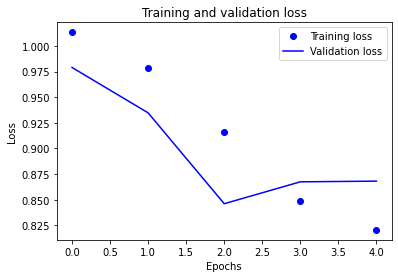

In [ ]:
#Plots 
plt.plot(range(0, epoch_count-1), train_losses, 'bo', label='Training loss')
plt.plot(range(0, epoch_count-1), test_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

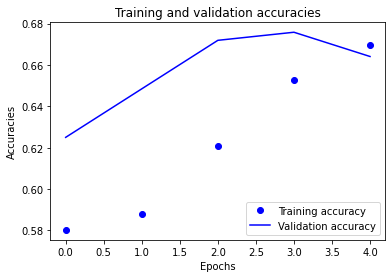

In [ ]:
plt.plot(range(0, epoch_count-1), train_accuracies, 'bo', label='Training accuracy')
plt.plot(range(0, epoch_count-1), test_accuracies, 'b', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend()

plt.show()

In [ ]:
# Prediction
model.load_state_dict(torch.load('drive/MyDrive/TwitterProject/saved_models/BERT-b1-r1-h256-d6-blr1e-5.pt'))

<All keys matched successfully>

In [ ]:
test_loss, test_acc, confusion, predictions, labels = test(model=model,
                            iterator=test_loader,
                            criterion=criterion,
                            device=DEVICE,
                            include_bert_masks=True)

print(f'Test Loss:  {test_loss:.3f} | Test Accuracy:  {test_acc * 100:.2f}%')
print(f"F1: {f1}")
print(f'Test confusion:\n{confusion}')

TypeError: ignored

In [ ]:
def predict(tweet, header_id, print_results = False):
    labels = ["agree", "disagree", "no_stance", "not_relevant"]

    prediction = model.predict(tweet, header_id)
    if print_results:
        print("Target: " + targets[target_idx.index(header_id)])
        print("Tweet: " + tweet)
        print(labels[torch.argmax(prediction, dim=-1)])
    return labels[torch.argmax(prediction, dim=-1)]

In [ ]:
tweets = dict()
outputs = []
with open('drive/MyDrive/TwitterProject/test_data/test_tweets.jsonl') as f:
    for line in f:
        obj = json.loads(line)
        tweets[obj['id']] = obj['text']

with open('drive/MyDrive/TwitterProject/test_data/test_candidates.jsonl') as f:
    for line in f:
        obj = json.loads(line)
        tweet_id = obj['tweet_id']
        tweet = tweets[tweet_id]
        m_id = int(obj['m_id'])
        prediction = predict(tweet, m_id)
        output = dict()
        output['tweet_id'] = tweet_id
        output['m_id'] = str(m_id)
        output['m_label'] = prediction
        outputs.append(json.dumps(output))

with open('drive/MyDrive/TwitterProject/test_data/output/X1_test_outputs.jsonl', 'w+') as f:
    for line in outputs:
        f.write(line + "\n")

In [ ]:
tweet = "@JCope222 Vaccine is untested for safety. People have died in he trials. Natural immunity scores 99.975% recovery from Covid for your age group"
header_id = 1

predict(tweet, header_id)